In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

In [ ]:
tf.__version__

'2.17.1'

In [ ]:
%load_ext tensorboard

In [ ]:
logdir = 'logs/images'

In [ ]:
# Carregar o conjunto de dados MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Pré-processamento
def preprocess_data(images, labels):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0
    return images, labels

train_images, train_labels = preprocess_data(train_images, train_labels)
test_images, test_labels = preprocess_data(test_images, test_labels)

In [ ]:
# Definindo as classes
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# Criando o modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
      # Cálculo de métricas de aprendizado
def calculate_metrics():
    test_pred = np.argmax(model.predict(test_images), axis=-1)

    con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()

    vp = np.diag(con_mat)
    fn = con_mat.sum(axis=1) - vp
    fp = con_mat.sum(axis=0) - vp
    vn = con_mat.sum() - (fp + fn + vp)

    accuracy = (vp.sum()) / con_mat.sum()
    precision = np.mean(vp / (vp + fp))
    sensitivity = np.mean(vp / (vp + fn))
    specificity = np.mean(vn / (vn + fp))
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("F1 Score:", f1_score)

calculate_metrics()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Accuracy: 0.9904
Precision: 0.9904803821670312
Sensitivity: 0.9902001645609116
Specificity: 0.9989322757733843
F1 Score: 0.9903402535420199


In [ ]:
# Treinando o modelo
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels), verbose=1)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 34ms/step - accuracy: 0.8865 - loss: 0.3646 - val_accuracy: 0.9870 - val_loss: 0.0400
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.9847 - loss: 0.0502 - val_accuracy: 0.9874 - val_loss: 0.0354
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9904 - loss: 0.0310 - val_accuracy: 0.9900 - val_loss: 0.0326
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9924 - loss: 0.0245 - val_accuracy: 0.9895 - val_loss: 0.0317
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9904 - val_loss: 0.0359


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


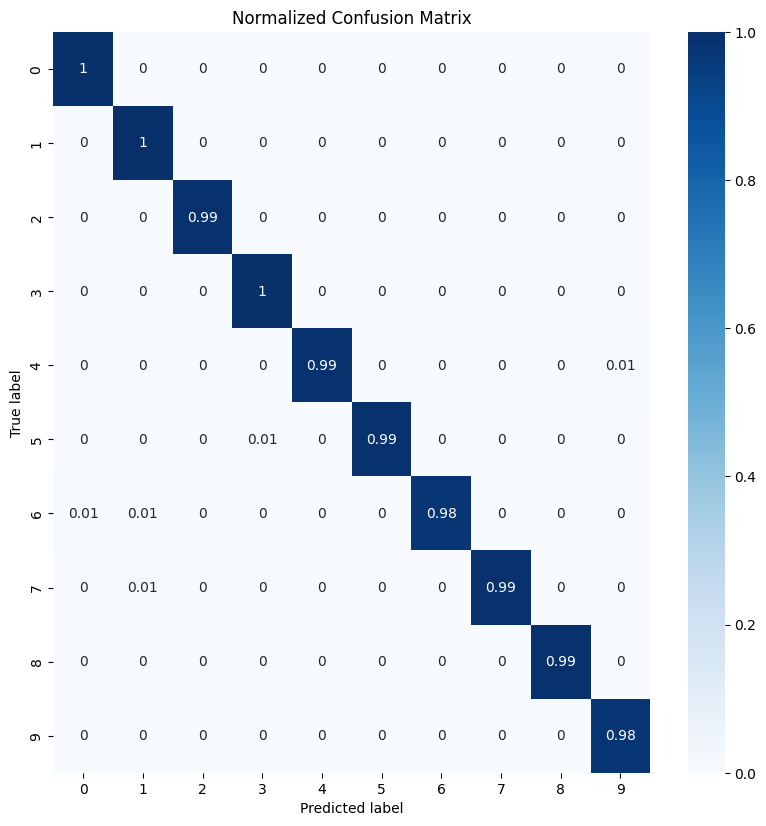

In [ ]:
# Predições e cálculo da matriz de confusão
def plot_confusion_matrix():
    test_pred = np.argmax(model.predict(test_images), axis=-1)

    con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)

    plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

plot_confusion_matrix()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


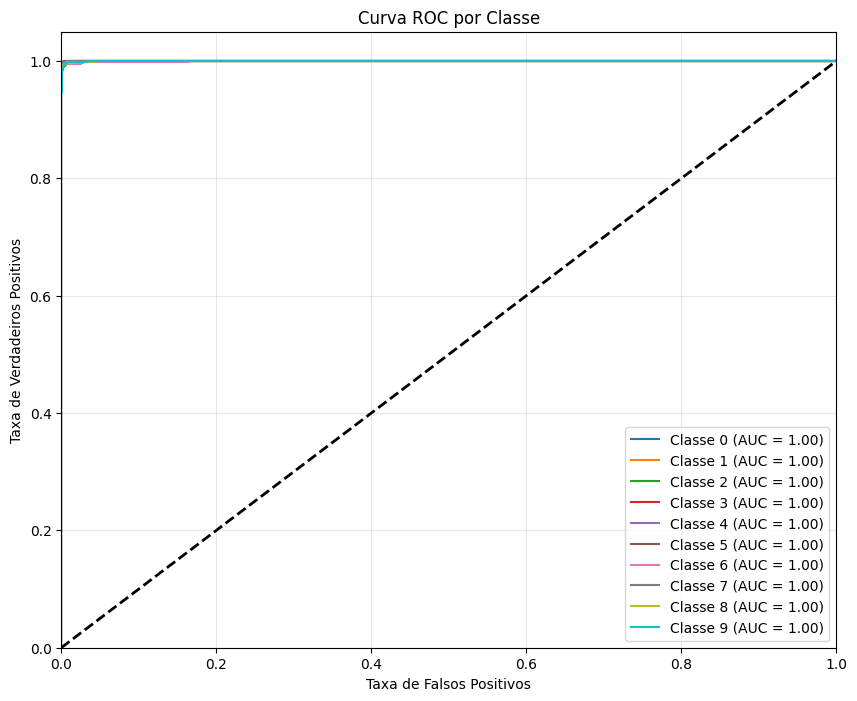

In [ ]:
# Gráfico ROC
def plot_roc_curve():
    # Binarizar as labels para cálculo One-vs-Rest
    y_test_bin = label_binarize(test_labels, classes=classes)
    y_score = model.predict(test_images)

    plt.figure(figsize=(10, 8))

    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC por Classe')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curve()